In [1]:
## Notebook env: mirtud_env (R kernel)
## This notebook creates a cell profile hierachial clusetering heatmap (Fig.2A Replogle et al)
## It also classifies cells from each pertubations into different pathways (Fig.4A and 4B Replogle et al)
## Annotate the controls as one control 'TuD_NC' so they are all one (sample cells if needed to lower cell #)


library(Matrix)
library(Seurat)
library(stringr)
library(ggplot2)
library(dbscan)
library(ggpubr)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendrogram




In [ ]:
## To run notebook interactively, shut off variable inspector:
#system("jupyter labextension disable @lckr/jupyterlab_variableinspector", intern = TRUE)

character(0)

In [ ]:
### Data loading ###
miR_loaded_seuratobj <- readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_normalized_integrated_seurat.rds')
meta = miR_loaded_seuratobj@meta.data

meta$guide[str_sub(meta$guide, 1, 3) == 'TuD'] <- 'TuD_NC'
miR_loaded_seuratobj@meta.data <- meta
head(miR_loaded_seuratobj@meta.data)

In [4]:
length(unique(meta$guide))

[1] 378

Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


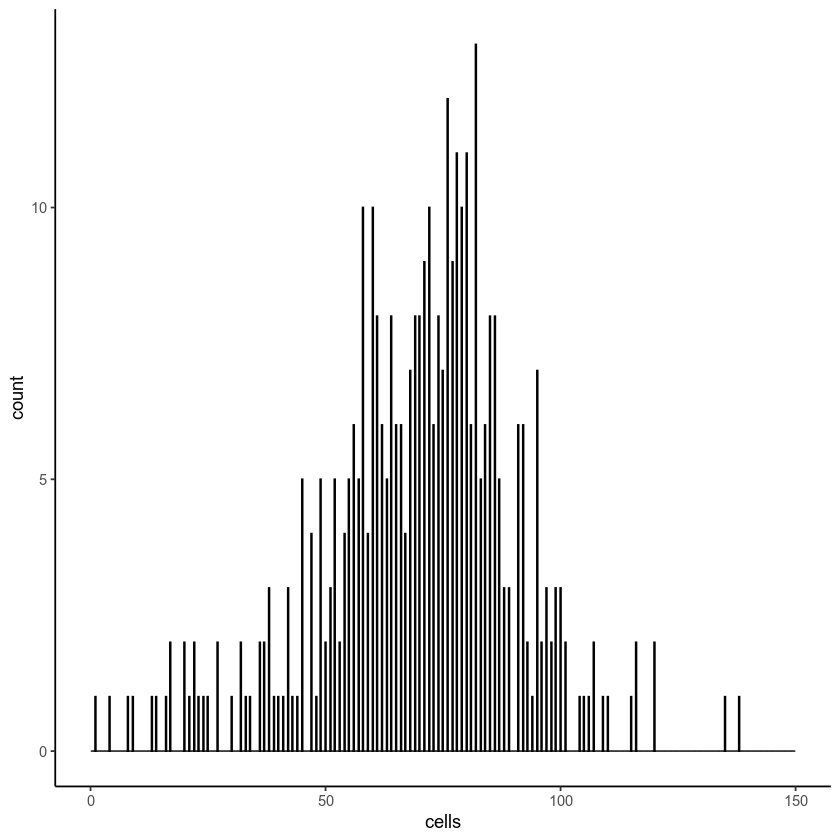

In [4]:
count_df = data.frame(guide = names(table(meta$guide)), cells = as.numeric(table(meta$guide)))
ggplot(count_df, aes(x = cells)) + geom_histogram(color="black", fill="white", position = "identity", bins = 1000) + 
xlim(0,150) + theme_classic()

In [5]:
suppressWarnings(library(dplyr))
cbind(arrange(count_df, cells)[1:10,], arrange(count_df, -cells)[1:10,])


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,guide,cells,guide,cells
,<chr>,<dbl>,<chr>,<dbl>
1,hsa-miR-92a-3p,1,TuD_NC,3101
2,hsa-miR-20a-5p,4,hsa-miR-3605-5p,138
3,hsa-miR-92b-3p,8,hsa-miR-122-5p,135
4,hsa-let-7a-5p,9,hsa-miR-10527-5p,120
5,hsa-miR-221-3p,13,hsa-miR-1255a,120
6,hsa-miR-106b-5p,14,hsa-miR-3928-3p,116
7,hsa-miR-19b-3p,16,hsa-miR-4677-3p,116
8,hsa-miR-222-3p,17,hsa-miR-3662,115
9,hsa-miR-93-5p,17,hsa-miR-489-3p,110


In [6]:
### seems like # of cells per guide is a huge covariate in expression (based on heatmap below without regressing it out)
## so need to control for it here
cell_guide_count = 1:nrow(meta)
for (i in 1:nrow(count_df)){
    cell_guide_count[meta$guide == count_df$guide[i]] = count_df$cells[i]
}

meta$cell_guide_count = cell_guide_count
miR_loaded_seuratobj@meta.data <- meta

In [8]:
miR_seuratobj = CreateSeuratObject(miR_loaded_seuratobj@assays$RNA@counts, meta.data = miR_loaded_seuratobj@meta.data)
miR_seuratobj = SCTransform(miR_seuratobj, vars.to.regress = c('sample', 'percent.mt', 'nCount_RNA', 'cell_guide_count'))

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 26540 by 29348

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 80 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 26540 genes



  |======================================================================| 100%


Computing corrected count matrix for 26540 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 29.38159 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out sample, percent.mt, nCount_RNA, cell_guide_count

Centering data matrix

Set default assay to SCT



In [49]:
saveRDS(miR_seuratobj, '/home/ssobti/projects/mir_tud/output_data/genexp_pathway/miR_sctransformed_seurat.rds')

In [7]:
miR_seuratobj = readRDS('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/miR_sctransformed_seurat.rds')

In [8]:
### For Fig2A, first take normalized gene expression averages
## to build pseudo-bulk expression profile for each perturbation
Pseudo_bulk_exp <- AverageExpression(miR_seuratobj, assays = "SCT", group.by = "guide", slot = "scale.data")
Pseudo_bulk_exp <- Pseudo_bulk_exp[['SCT']]

In [9]:
range(Pseudo_bulk_exp)

[1] -4.703333 24.103890

In [10]:
dim(Pseudo_bulk_exp)

[1] 3000  378

In [ ]:
## run spearman correlation on Pseudo_bulk_exp matrix
perturb_perturb_corr_mtx <- cor(Pseudo_bulk_exp, method = 'spearman')

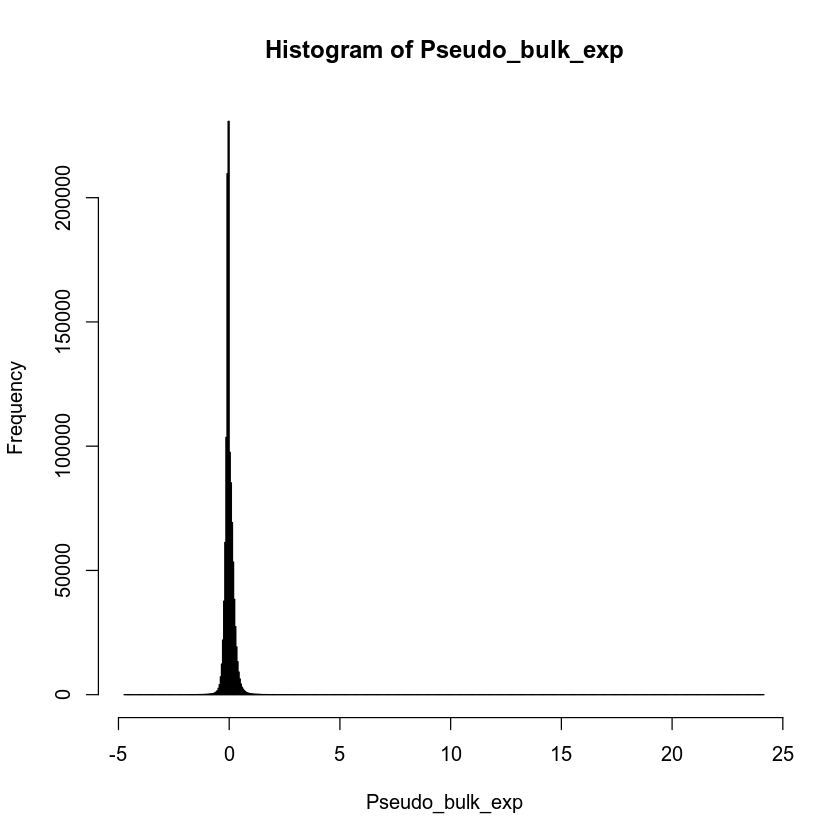

In [12]:
options(repr.plot.width = 7, repr.plot.height = 7)
hist(Pseudo_bulk_exp, breaks = 1000)

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



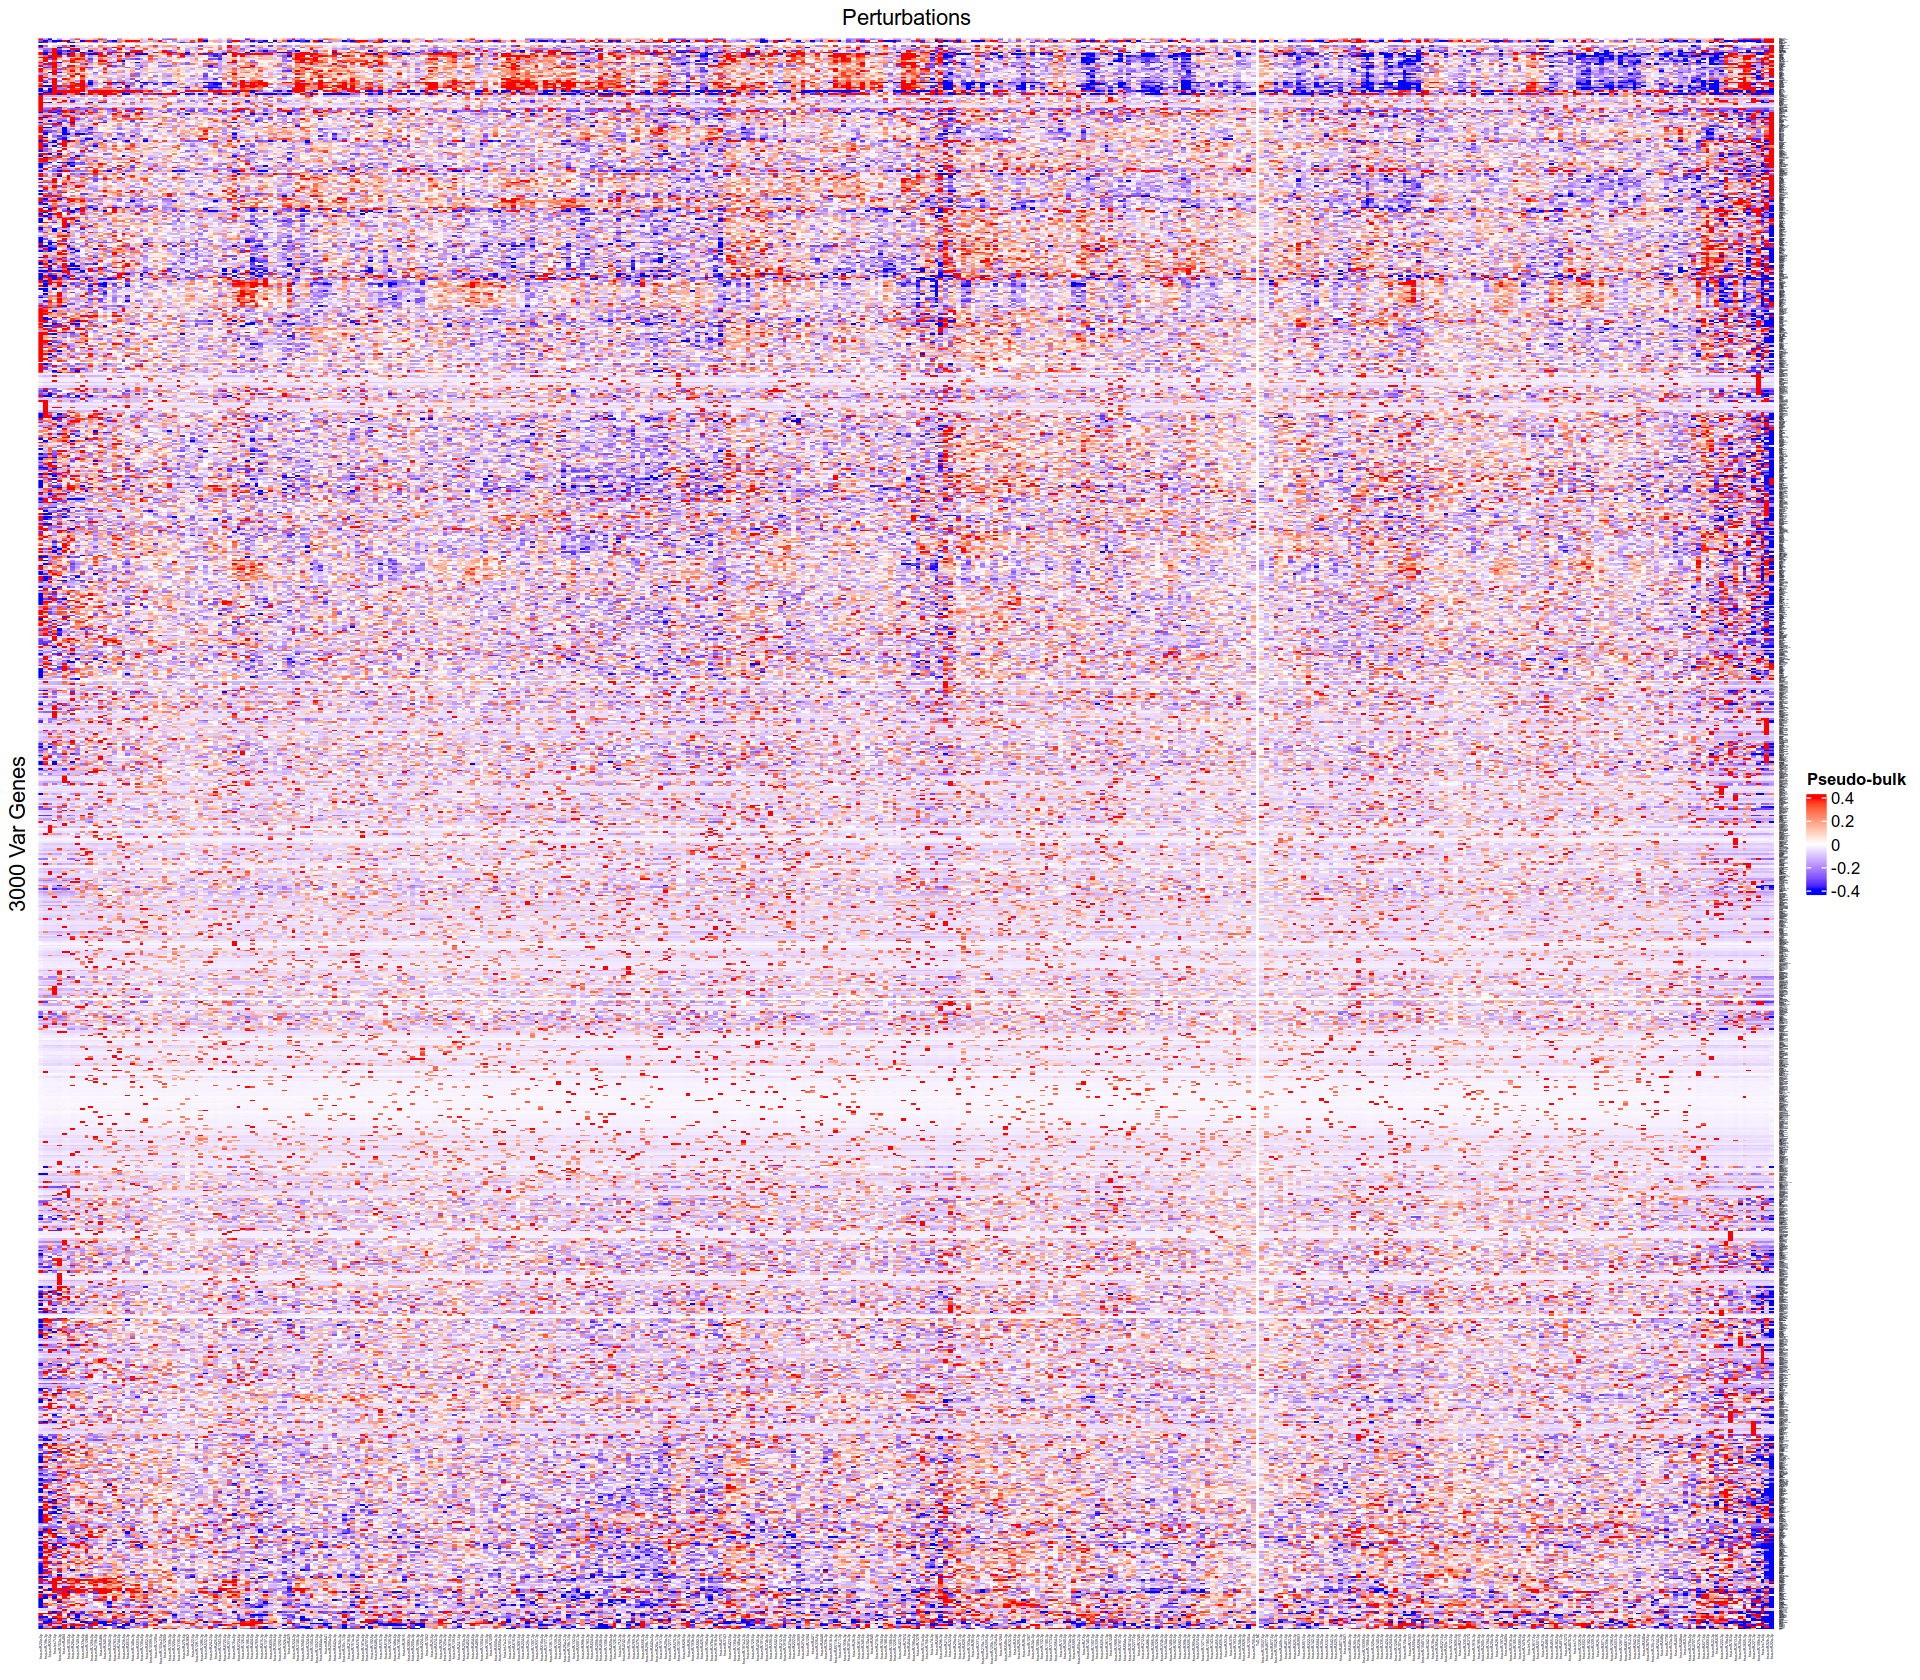

In [13]:
#### Gene Expression by Perturbation Heatmap (Replogle Fig.2A pt.1) ####
suppressWarnings(library(ComplexHeatmap))
suppressWarnings(library(gridExtra))

avg = mean(Pseudo_bulk_exp)
lower_bound = mean(Pseudo_bulk_exp) - 2*sd(Pseudo_bulk_exp)
upper_bound = mean(Pseudo_bulk_exp) + 2*sd(Pseudo_bulk_exp)
coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = FALSE, use_raster = TRUE, row_title = '3000 Var Genes', 
               column_title = 'Perturbations', row_title_side = 'left', column_title_side = 'top', 
               column_names_gp = gpar(fontsize = 2), row_names_gp = gpar(fontsize = 1)))
}


options(repr.plot.width = 16, repr.plot.height = 14)
pdf('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/avg_genexp_htmap.pdf', width = 12, height = 11)
perturb_htmp(Pseudo_bulk_exp, 'Pseudo-bulk')
dev.off()

perturb_htmp(Pseudo_bulk_exp, 'Pseudo-bulk')

In [ ]:
## save data to rds
saveRDS(Pseudo_bulk_exp, '/home/ssobti/projects/mir_tud/fig_output/data/fig2/miR_pseudo_bulk_exp.rds')

In [17]:
perturb_perturb_corr_mtx[1:3,1:3]

,hsa-let-7a-2-3p,hsa-let-7a-5p,hsa-let-7b-3p
hsa-let-7a-2-3p,1.00000000,0.10131604,0.07173595
hsa-let-7a-5p,0.10131604,1.00000000,0.04402341
hsa-let-7b-3p,0.07173595,0.04402341,1.00000000


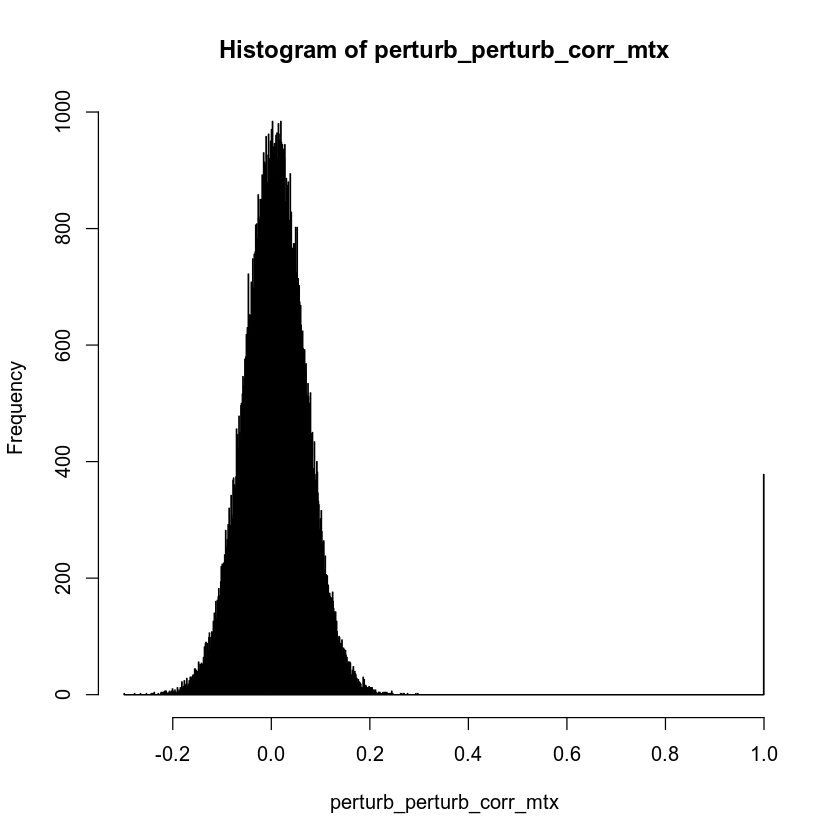

In [18]:
options(repr.plot.width = 7, repr.plot.height = 7)
hist(perturb_perturb_corr_mtx, breaks = 1000)

In [19]:
mean(perturb_perturb_corr_mtx) + 2*sd(perturb_perturb_corr_mtx)

[1] 0.1700095

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



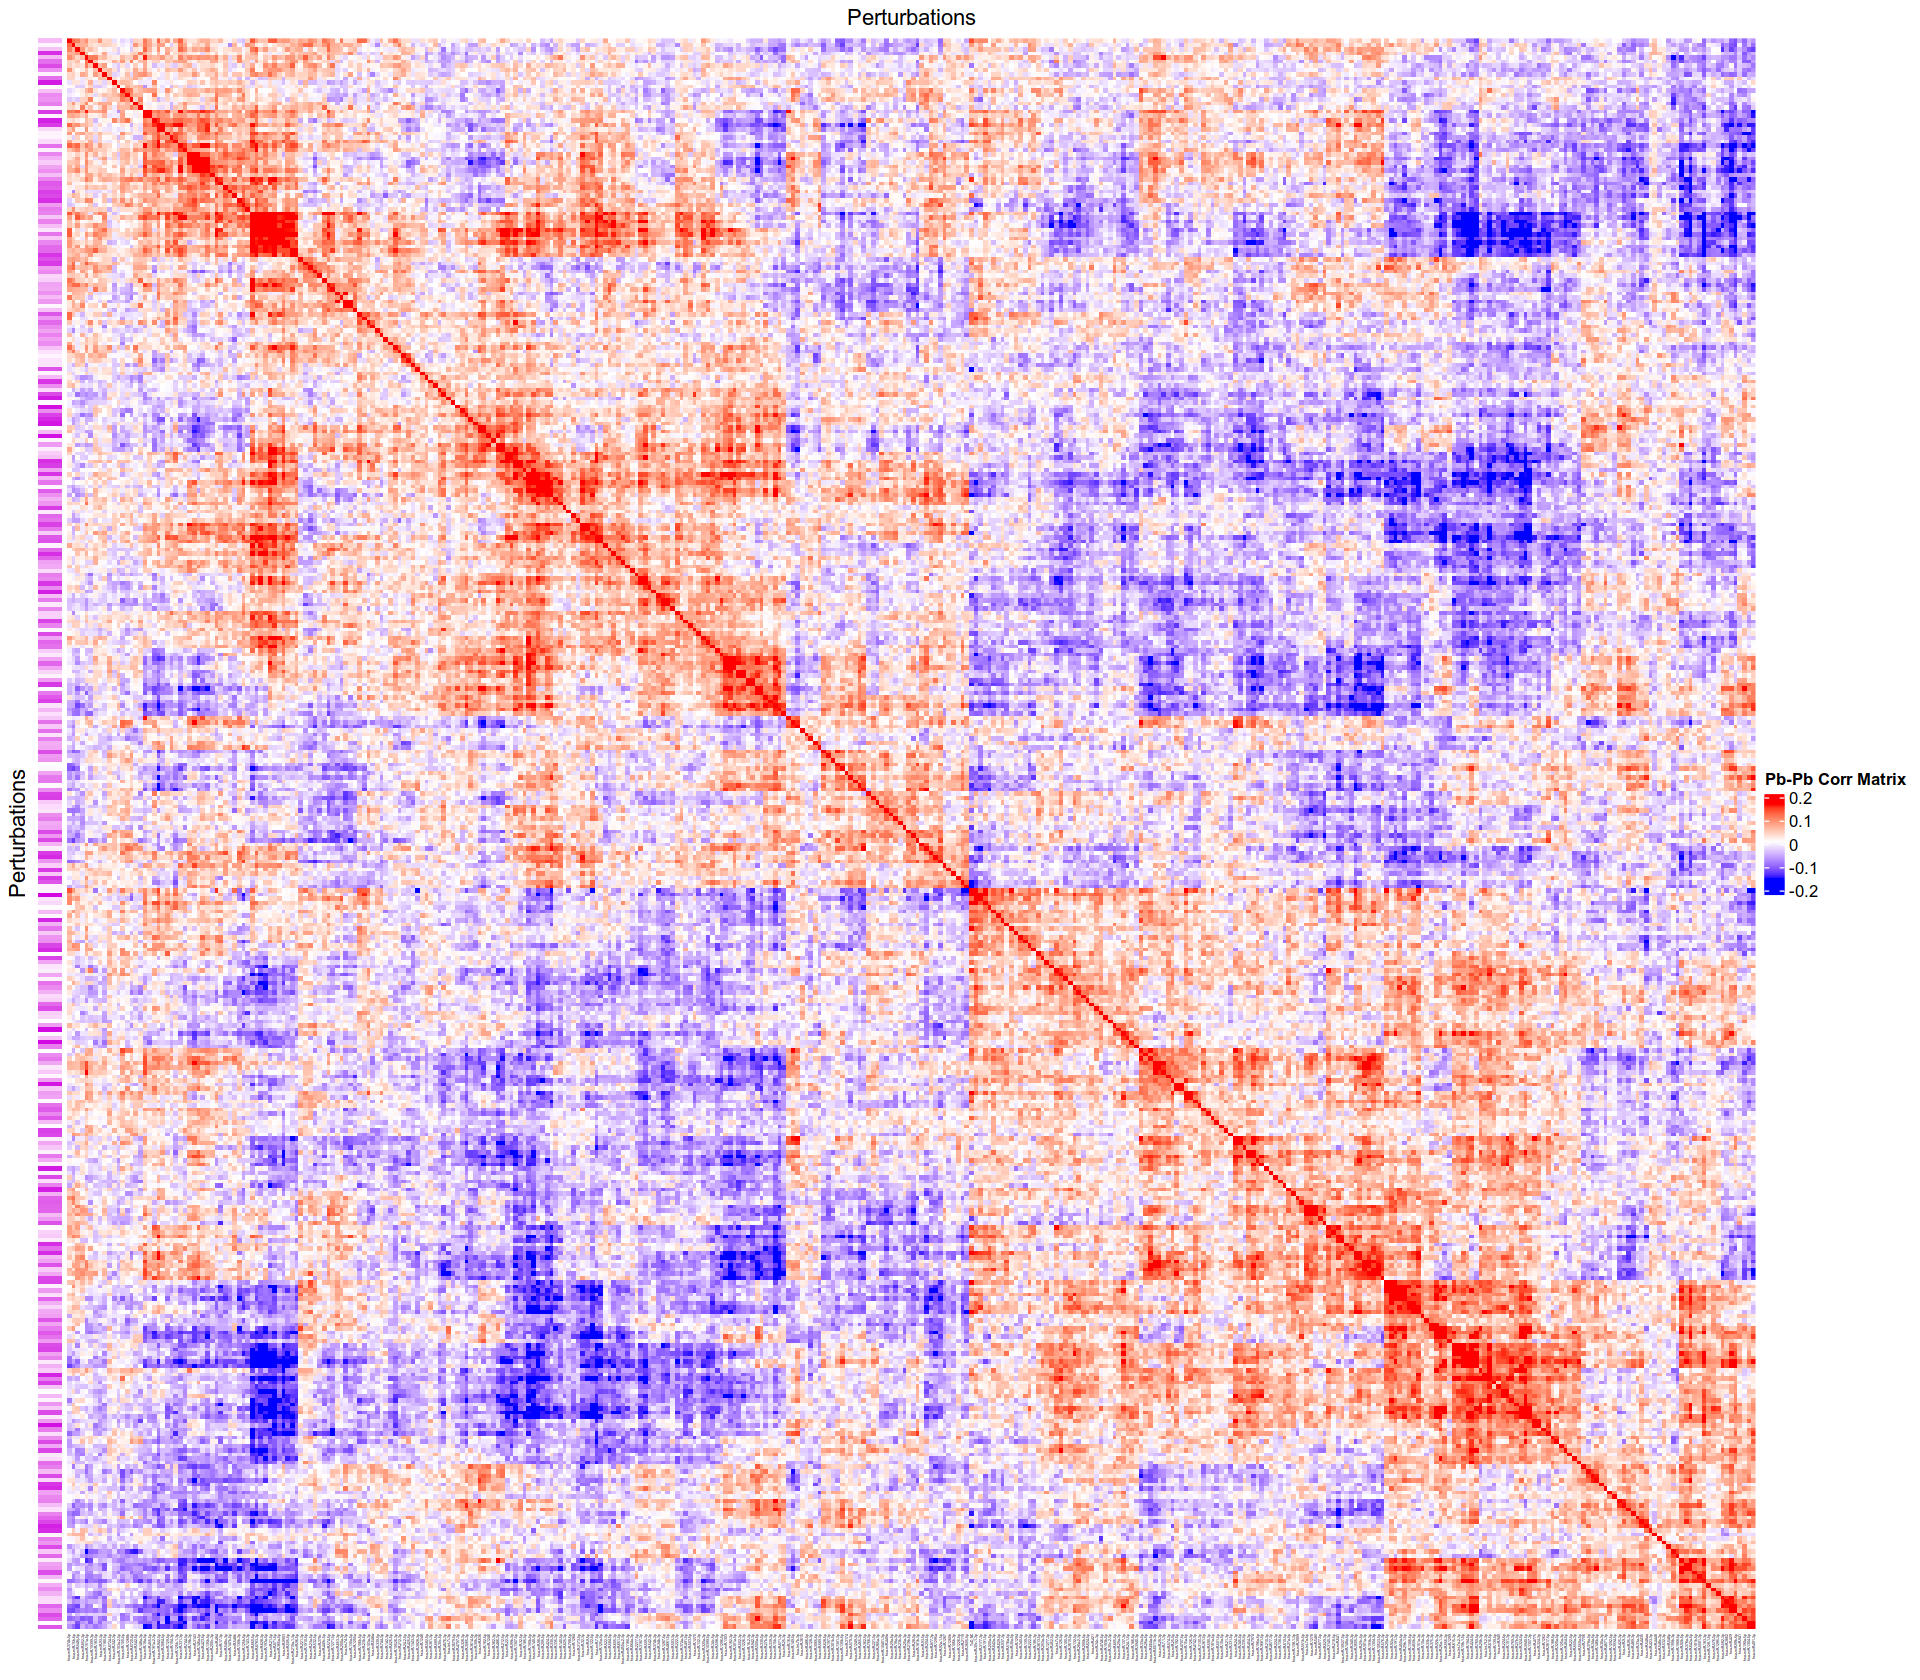

In [17]:
#### Perturbation - Perturbation Spearman Correlation Matrix (Replogle Fig.2A pt.2) ####
set.seed(20)
avg = mean(perturb_perturb_corr_mtx)
lower_bound = mean(perturb_perturb_corr_mtx) - 2*sd(perturb_perturb_corr_mtx)
upper_bound = mean(perturb_perturb_corr_mtx) + 2*sd(perturb_perturb_corr_mtx)
coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

annot = rowAnnotation(perturb = runif(nrow(perturb_perturb_corr_mtx)), show_legend = FALSE, show_annotation_name = FALSE)

perturb_perturb_corr_mtx_htmp <- function(matrix, title, annotation) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = FALSE, show_column_dend = FALSE,
               col = coloring_map, show_row_dend = FALSE, use_raster = TRUE, row_title = 'Perturbations', 
               column_title = 'Perturbations', row_title_side = 'left', column_title_side = 'top', 
               column_names_gp = gpar(fontsize = 2), row_names_gp = gpar(fontsize = 1),
               left_annotation = annotation))
}


options(repr.plot.width = 16, repr.plot.height = 14)
pdf('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/avg_genexp_corr_htmap.pdf', width = 12, height = 11)
perturb_perturb_corr_mtx_htmp(perturb_perturb_corr_mtx, 'Pb-Pb Corr Matrix', annot)
dev.off()

perturb_perturb_corr_mtx_htmp(perturb_perturb_corr_mtx, 'Pb-Pb Corr Matrix', annot)

In [ ]:
saveRDS(perturb_perturb_corr_mtx, '/home/ssobti/projects/mir_tud/fig_output/data/fig2/miR_perturb_perturb_corr_mtx.rds')

### Correlation within miR families vs correlation between equivalent families made of random unique guides ###

In [1]:
suppressWarnings(library(tidyverse))
perturb_perturb_corr_mtx = readRDS('/home/ssobti/projects/mir_tud/fig_output/data/fig2/miR_perturb_perturb_corr_mtx.rds')
adata.miR = readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_normalized_integrated_seurat.rds')
meta = adata.miR@meta.data
guide_to_family_key = meta[,c('guide', 'miR.family')] %>% distinct()
guide_to_family_key = guide_to_family_key[!startsWith(guide_to_family_key$guide, 'TuD_NC'),]
guide_to_family_key$family_status = ifelse(grepl('/', guide_to_family_key$miR.family), 'Family', 'Unique')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
## get miR families and their intrafamily correlations values (minus miR self-correlations)
families = guide_to_family_key %>% filter(family_status == 'Family') %>% pull(miR.family) %>% unique()
families_miR_dictionary_list = lapply(families, function(x) {guide_to_family_key$guide[guide_to_family_key$miR.family == x]})
names(families_miR_dictionary_list) = families
families_miR_dictionary_list = families_miR_dictionary_list[lapply(families_miR_dictionary_list, function(x) {length(x)}) > 1]  ## 19 families present

family_subset_corr_mtxs = lapply(families_miR_dictionary_list, function(x) {perturb_perturb_corr_mtx[x,x]})
intrafamily_r_values_w_removed_self_correlations = lapply(lapply(family_subset_corr_mtxs, as.numeric), function(x) x[!(x == 1)])

In [3]:
## make families from random unique miR guides to compare with miR families
## get their intrafamily correlations values (minus self-correlations)
families_miR_constituent_count = lapply(families_miR_dictionary_list, length)

set.seed(123)
random_unique_guides = guide_to_family_key %>% filter(!(guide %in% unlist(families_miR_dictionary_list))) %>% pull(guide) %>% sample(x = .,size = sum(as.numeric(families_miR_constituent_count)), replace = FALSE)
splitting_order = mapply(FUN = rep, 1:length(names(families_miR_constituent_count)), as.numeric(families_miR_constituent_count)) %>% unlist() %>% as.character()
random_unique_guides_list = split(random_unique_guides, splitting_order)
random_unique_guides_list = random_unique_guides_list[order(as.numeric(names(random_unique_guides_list)))]

random_unique_guides_subset_corr_mtxs = lapply(random_unique_guides_list, function(x) {perturb_perturb_corr_mtx[x,x]})
intrarandom_unique_guides_r_values_w_removed_self_correlations = lapply(lapply(random_unique_guides_subset_corr_mtxs, as.numeric), function(x) x[!(x == 1)])

In [5]:
## get median correlation for each family and random unique family
median_intrafamily_r_values_w_removed_self_correlations = lapply(intrafamily_r_values_w_removed_self_correlations, median)
median_intrarandom_unique_guides_r_values_w_removed_self_correlations = lapply(intrarandom_unique_guides_r_values_w_removed_self_correlations, median)

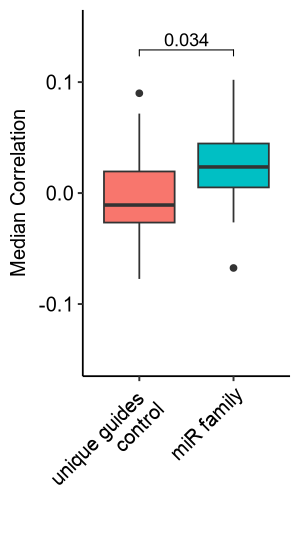

In [ ]:
## plot
df = rbind(data.frame(family = names(median_intrafamily_r_values_w_removed_self_correlations), median_correlation = unlist(median_intrafamily_r_values_w_removed_self_correlations), family_status = 'miR_family') , 
           data.frame(family = names(median_intrafamily_r_values_w_removed_self_correlations), median_correlation = unlist(median_intrarandom_unique_guides_r_values_w_removed_self_correlations), family_status = 'random_unique_guides'))
rownames(df) = NULL
df$family_status[df$family_status == 'random_unique_guides'] = 'unique guides \n control'
df$family_status[df$family_status == 'miR_family'] = 'miR family'
df$family_status = factor(df$family_status, levels = c('unique guides \n control', 'miR family'))
# saveRDS(df, '/home/ssobti/projects/mir_tud/fig_output/data/fig2/miR_family_vs_random_unique_guides_correlation_values.rds')

options(repr.plot.width = 2.5, repr.plot.height = 4.5)
comparison = list(c('unique guides \n control', 'miR family'))
df %>% ggplot(aes(x = family_status, y = median_correlation, fill = family_status)) + xlab('') + geom_boxplot(show.legend = FALSE) + 
ggpubr::theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) +
scale_fill_discrete() + ylab('Median Correlation') + ggpubr::stat_compare_means(comparisons = comparison,label.y = 0.12) + ylim(c(-0.15, 0.15)) #+ ggtitle('Intrafamily vs Intrarandom Unique miR Guides Correlation Values') + theme(legend.position = 'none')

### Correlations between TuD_NCs vs between miR perturbations ###

In [3]:
miR_loaded_seuratobj <- readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_normalized_integrated_seurat.rds')
orig_meta = miR_loaded_seuratobj@meta.data

miR_seuratobj = readRDS('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/miR_sctransformed_seurat.rds')
meta = miR_seuratobj@meta.data
meta$original_guide = orig_meta$guide
miR_seuratobj@meta.data = meta

In [20]:
Pseudo_bulk_exp <- AverageExpression(miR_seuratobj, assays = "SCT", group.by = "original_guide", slot = "scale.data")
Pseudo_bulk_exp <- Pseudo_bulk_exp[['SCT']]
perturb_perturb_corr_mtx <- cor(as.matrix(Pseudo_bulk_exp), method = 'pearson')

In [21]:
control_mtx = perturb_perturb_corr_mtx[startsWith(rownames(perturb_perturb_corr_mtx), 'TuD-NC'), startsWith(colnames(perturb_perturb_corr_mtx), 'TuD-NC')]
miR_mtx = perturb_perturb_corr_mtx[!startsWith(rownames(perturb_perturb_corr_mtx), 'TuD-NC'), !startsWith(colnames(perturb_perturb_corr_mtx), 'TuD-NC')]

control_corrs = control_mtx[upper.tri(control_mtx, diag = FALSE)]
miR_corrs = miR_mtx[upper.tri(miR_mtx, diag = FALSE)]

df = data.frame(guide = c(rep('control', length(control_corrs)), rep('miR', length(miR_corrs))), correlation = c(control_corrs, miR_corrs))
df$correlation = abs(df$correlation)

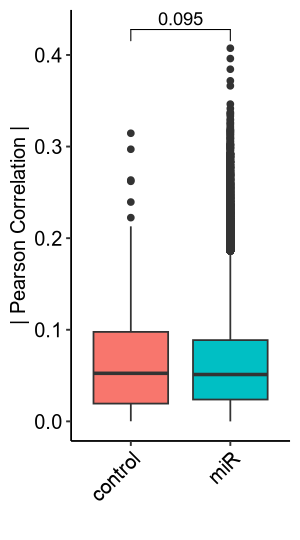

In [45]:
options(repr.plot.width = 2.5, repr.plot.height = 4.5)
comparison = list(c('control', 'miR'))
ggplot(df, aes(x = guide, y = correlation, fill = guide)) + xlab('') + geom_boxplot(show.legend = FALSE) + 
ggpubr::theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) +
scale_fill_discrete() + ylab('| Pearson Correlation |') + ggpubr::stat_compare_means(method = 't.test', comparisons = comparison, method.args = list(alternative = "greater")) #+ ylim(c(-0.15, 0.15))